## Описание алгоритма стохастического градиентного спуска с мини-батчами

Данный код реализует алгоритм стохастического градиентного спуска (SGD) с использованием мини-батчей для аппроксимации функции:

$$f(x) = 0.5 \cdot x + 0.2 \cdot x^2 - 0.05 \cdot x^3 + 0.2 \cdot \sin(4x) - 2.5$$

на интервале $[-4, 6]$ моделью вида:

$$a(x) = w_0 + w_1 \cdot x + w_2 \cdot x^2 + w_3 \cdot x^3$$

**Цель:** Найти вектор параметров $w = [w_0, w_1, w_2, w_3]^T$, минимизирующий усеченный эмпирический риск $Q_k(w)$.

**Усеченный эмпирический риск:**

$$Q_k(w) = \frac{1}{K} \sum_{i=k}^{k+K-1} (a(x_i, w) - y_i)^2 = \frac{1}{K} \sum_{i=k}^{k+K-1} (w^T \cdot x_i - y_i)^2$$

где:
- $k$ - случайно выбранный начальный индекс мини-батча.
- $K$ (`batch_size` в коде) - размер мини-батча.
- $a(x_i, w)$ - значение модели в точке $x_i$ с текущими параметрами $w$.
- $y_i$ - истинное значение функции в точке $x_i$.

**Алгоритм стохастического градиентного спуска с мини-батчами:**

Параметры $w$ обновляются итеративно по следующей формуле:

$$w_n = w_{n-1} - \eta \cdot \frac{\partial Q_k(w)}{\partial w}$$

где:
- $w_n$ - вектор параметров на текущей итерации.
- $w_{n-1}$ - вектор параметров на предыдущей итерации.
- $\eta$ - шаг обучения (learning rate).
- $\frac{\partial Q_k(w)}{\partial w}$ - градиент усеченного эмпирического риска по вектору параметров $w$ для случайно выбранного мини-батча.

**Градиент усеченного эмпирического риска:**

Производная усеченного показателя качества по вектору параметров $w$ для мини-батча:

$$\frac{\partial Q_k(w)}{\partial w} = \frac{2}{K} \sum_{i=k}^{k+K-1} (w^T \cdot x_i - y_i) \cdot x_i^T$$

где $x_i = [1, x, x^2, x^3]^T$ - вектор признаков для i-го образа.

**Матрица признаков X:**

Матрица признаков $X$ для всей выборки формируется таким образом, что каждая строка соответствует одной точке данных $x_i$ из интервала $[-4, 6]$. Столбцы матрицы содержат значения признаков для каждой точки, а именно:

- Первый столбец: константа 1 (для члена $w_0$)
- Второй столбец: значение $x_i$
- Третий столбец: значение $x_i^2$
- Четвертый столбец: значение $x_i^3$

Таким образом, матрица $X$ имеет размерность $n \times 4$, где $n$ - количество точек в выборке.

**Скользящее среднее ошибки:**

Для отслеживания сходимости в процессе обучения используется экспоненциальное скользящее среднее ошибки. На каждой итерации, после вычисления ошибки $Q_k$ для текущего случайно выбранного мини-батча, скользящее среднее $Qe$ обновляется по формуле:

$$Qe_i = \lambda \cdot Q_{k_i} + (1 - \lambda) \cdot Qe_{i-1}$$

где:
- $Qe_i$ - текущее значение скользящего среднего ошибки.
- $Q_{k_i}$ - ошибка на текущей итерации для выбранного мини-батча.
- $\lambda$ (`lm` в коде) - параметр сглаживания.

**Реализация в коде:**

1.  Инициализируются начальные значения параметров $w$, шаги обучения $\eta$ и параметры `N` (число итераций), `lm` (параметр сглаживания) и `batch_size` (размер мини-батча).
2.  Создается матрица признаков $X$, включающая полиномиальные члены.
3.  В цикле, выполняющем `N` итераций:
    - Случайно выбирается начальный индекс `k` для мини-батча (`k = np.random.randint(0, sz-batch_size)`).
    - Извлекаются мини-батчи признаков (`X_batch`) и истинных значений (`y_batch`).
    - Вычисляется градиент по мини-батчу (`gradient_batch`).
    - Параметры $w$ обновляются с учетом шага обучения и вычисленного градиента (`w -= eta * gradient_batch`).
    - Вычисляется ошибка на текущем мини-батче (`Qk`) и обновляется скользящее среднее ошибки (`Qe`).
4.  После завершения итераций вычисляется и выводится итоговая среднеквадратичная ошибка ($Q$) для всей выборки, а также последнее значение скользящего среднего ошибки ($Qe$).

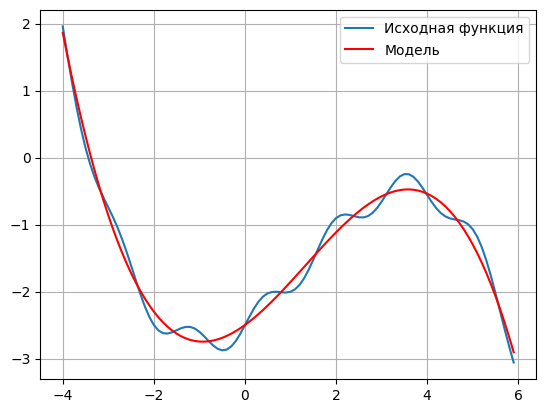

In [1]:
import numpy as np
import matplotlib.pyplot as plt # Добавлен импорт
np.random.seed(0) # генерация одинаковых последовательностей псевдослучайных чисел
# исходная функция, которую нужно аппроксимировать моделью a(x)
def func(x):
    return 0.5 * x + 0.2 * x ** 2 - 0.05 * x ** 3 + 0.2 * np.sin(4 * x) - 2.5


# здесь объявляйте необходимые функции


coord_x = np.arange(-4.0, 6.0, 0.1).reshape(-1,1) # 100x1
coord_y = func(coord_x).reshape(-1,1) # 100x1

sz = len(coord_x)       # количество значений функций (точек)
eta = np.array([0.1, 0.01, 0.001, 0.0001]).reshape(-1,1) #4x1
w = np.array([0., 0., 0., 0.]).reshape(-1,1) #4x1
N = 500 # число итераций алгоритма SGD
lm = 0.02 # значение параметра лямбда для вычисления скользящего экспоненциального среднего
batch_size = 50 # размер мини-батча (величина K = 50)
X = np.hstack((     #100x4
    np.ones_like(coord_x),
    coord_x,
    coord_x**2,
    coord_x**3
))
loss = (X@w - coord_y)**2 # 100x1
Qe = np.mean(loss)
for _ in range(N):
  k = np.random.randint(0,sz-batch_size+1)
  X_batch = X[k:k+batch_size] # 50x4
  y_batch = coord_y[k:k+batch_size] # 50x1
  gradient_batch = 2/batch_size * (X_batch.T @ (X_batch@w - y_batch))
  w -= eta * gradient_batch
  Qk = np.mean((X_batch@w - y_batch)**2)
  Qe = lm * Qk + (1-lm) * Qe

Q = np.mean((X@w - coord_y)**2)

# Код для отображения финального графика
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(coord_x, coord_y, label='Исходная функция')
ax.plot(coord_x, X @ w, c="red", label='Модель')
ax.legend()
plt.show()